# Overview

A major facet of the novel COVID-19 virus that reported numbers of cases in the EU and US during the first wave of Feb 2020 - May 2020 largely underestimates the true number of cases at the time. As testing was limited, the majority of reported positive cases came from those already admitted to hospital with heavy symptoms. During the second (and in some countries the third) wave, testing was far more extensive, which lead to the massive surges in numbers seen across the Western world.

Looking at the peaks in deaths across the worst affected [countries](https://www.worldometers.info/coronavirus/), they do not differ largely from the daily reported numbers during the first wave. Clearly, the number of deaths during any given wave contains intrinsic information regarding that actual number of infected people, regardless of how many are tested. If we work under the assumption that, up until the time of writing in January 2021, the mortality rate of COVID-19 and any of its mutations remain stable through time, it should be possible to gain an estimate of the actual infection rate during the first wave by using reported case/death information during subsequent waves.

In this notebook, we explore a couple of approaches to estimating the true number of COVID-19 cases in the UK during the first wave of the pandemic. No epidemiological modelling is done; all predictions are made with pure data-driven models. Naturally, this implies that no real policy should be based on these results, but it remains an intersting exercise to estimate the true extent of the pandemic when it - and our understanding of it - was at its infancy.

### Assumptions

Throughout the modelling process, certain assumptions are made in order to proceed with the data-driven approach. These must be kept in mind when interpreting the various steps

### Models

The first approach is ordinary linear regression (OLS), which makes the assumption

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use("ts-style.mplstyle")

# Data

The data used here is obtained from the UK government COVID-19 [website](https://coronavirus.data.gov.uk/).


In [2]:
df = pd.read_csv("Data/uk.csv")
df = df[::-1]
df.index = pd.to_datetime(df["date"], format="%d/%m/%Y")

In [3]:
data = df[["newCasesBySpecimenDate", "cumCasesBySpecimenDate", "newDeaths28DaysByDeathDate", "cumDeaths28DaysByDeathDate"]]
data.columns = ["Daily New Cases", "Cumulative Cases", "Daily New Deaths", "Cumulative Deaths"]

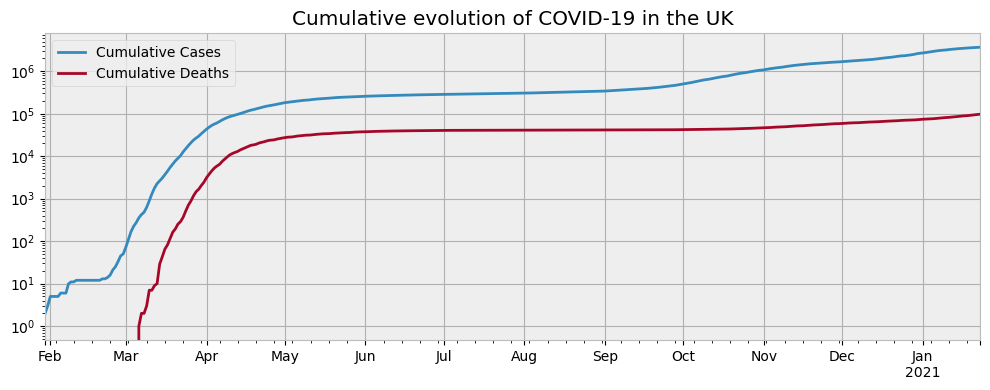

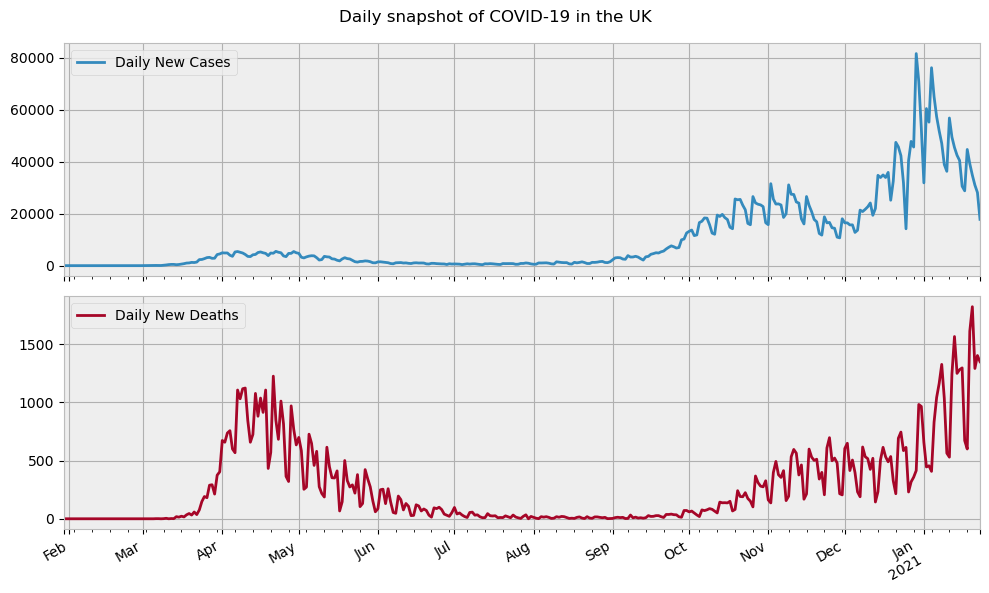

In [4]:
kw1 = dict(
    figsize=(10,4),
    xlabel="",
    title="Cumulative evolution of COVID-19 in the UK",
    logy=True
)

kw2 = dict(
    figsize=(10,6),
    subplots=True,
    sharex=True,
    xlabel="",
    title="Daily snapshot of COVID-19 in the UK"
)

data[["Cumulative Cases", "Cumulative Deaths"]].plot(**kw1);
plt.tight_layout()

data[["Daily New Cases", "Daily New Deaths"]].plot(**kw2);
plt.tight_layout()

# Smooth level

Using a trend-seasonal decomposition to smoothen data

In [5]:
switch_point = "2020-08-01"

In [163]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

decomp_cases_fit  = UnobservedComponents(data.loc[switch_point:]["Daily New Cases"], level="strend", seasonal=7).fit()
decomp_deaths_fit = UnobservedComponents(data.loc[switch_point:]["Daily New Deaths"], level="strend", seasonal=7).fit()

#decomp_cases_fit.plot_components(legend_loc="upper left", figsize=(10, 16));

C:\Users\Gebruiker\anaconda3\envs\TLRenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Gebruiker\anaconda3\envs\TLRenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


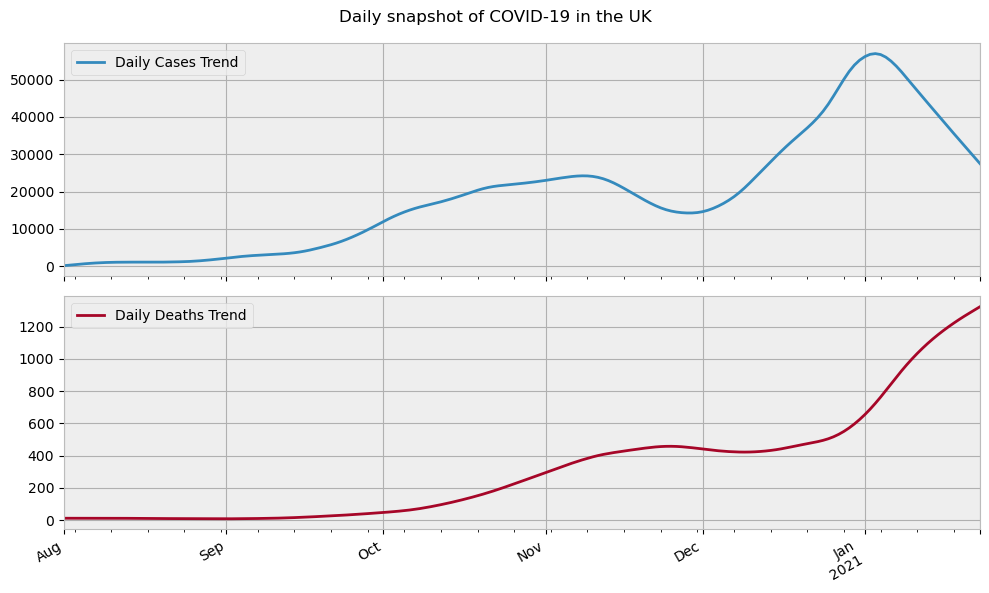

In [169]:
smoothed_cases  = pd.Series(decomp_cases_fit.level["smoothed"], index=data[switch_point:].index)
smoothed_deaths = pd.Series(decomp_deaths_fit.level["smoothed"], index=data[switch_point:].index)

latent_data = pd.concat((smoothed_cases, smoothed_deaths), axis=1)
latent_data.columns = cols = ["Daily Cases Trend", "Daily Deaths Trend"]

latent_data.plot(**kw2);
plt.tight_layout()

# Cycle extraction

Estimate cycle using the HP filter ([Hodrick & Prescott (1997)](https://www.jstor.org/stable/2953682?origin=crossref&seq=1)), which is typically used for business cycle extraction. Smoothing parameter is found by multiplying the standard 1600 value by the fourth power of the freqeuncy ratio ([Ravn & Uhlig (2006)](https://www.mitpressjournals.org/doi/10.1162/003465302317411604)).

In [170]:
HP_frequency = 13*7 # 1 quarter = 13 weeks x 7 days
lam = 1600*(HP_frequency**4) # -> \infty for high frequncy data

In [171]:
from statsmodels.tsa.filters import hp_filter

C_CYCLE, a = hp_filter.hpfilter(latent_data["Daily Cases Trend"], lamb=lam)
D_CYCLE, b = hp_filter.hpfilter(latent_data["Daily Deaths Trend"], lamb=lam)

cycles = pd.DataFrame([C_CYCLE, D_CYCLE]).T

### Scaling

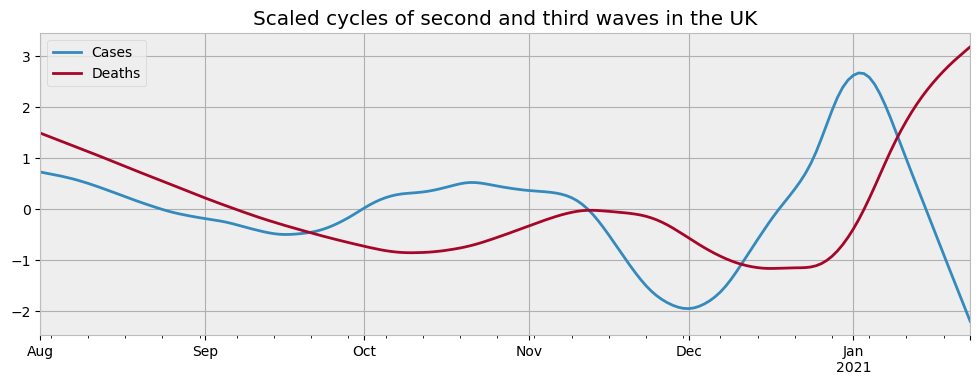

In [172]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
standard_scaler.fit(cycles)
scaled_cycles = pd.DataFrame(standard_scaler.transform(cycles),
                             index=data[switch_point:].index,
                             columns=["Cases", "Deaths"])

scaled_cycles.plot(figsize=(12, 4), title="Scaled cycles of second and third waves in the UK", xlabel="");

### Estimate time lag between cases and deaths

Apply a FFT to infer phase shift in the time domain.

In [173]:
import scipy as sp

n = len(scaled_cycles)
t = np.linspace(0.0, n)

YC = scaled_cycles["Cases"].values
YD = scaled_cycles["Deaths"].values

signal_corr = sp.signal.correlate(YC, YD, mode="full", method="fft")
dt = np.linspace(-t[-1], t[-1], 2*n-1)

t_shift = int(np.floor(dt[signal_corr.argmax()]))
phase = "lag behind" if t_shift < 0 else "lead ahead"

print(f"Cases are estimated to {phase} deaths by an average of {np.abs(t_shift)} days.")

#plt.plot(scaled_cycles["Cases"].shift(-t_shift).iloc[-t_shift:])
#plt.plot(scaled_cycles["Deaths"].iloc[-t_shift:]);

Cases are estimated to lag behind deaths by an average of 16 days.


# Establish a linear relationship

Very simple OLS modelling. No intercept implies that cases only exist when there are deaths, which is an unrealistic restriction. Nonetheless, since some epidemiological argument would need to be applied in order to justify 

In [174]:
ZC = latent_data["Daily Cases Trend"].shift(-t_shift).iloc[-t_shift:]
ZD = latent_data["Daily Deaths Trend"].iloc[-t_shift:]

lm = sm.OLS(ZC, ZD).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:      Daily Cases Trend   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              7096.
Date:                Tue, 26 Jan 2021   Prob (F-statistic):                   7.84e-134
Time:                        18:15:02   Log-Likelihood:                         -1525.9
No. Observations:                 160   AIC:                                      3054.
Df Residuals:                     159   BIC:                                      3057.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [175]:
mortality_rate = 100/lm.params[0]

print(f"During the second and third waves the mortality rate in the UK is estimated to be {mortality_rate:.2f}%.")

During the second and third waves the mortality rate in the UK is estimated to be 2.18%.


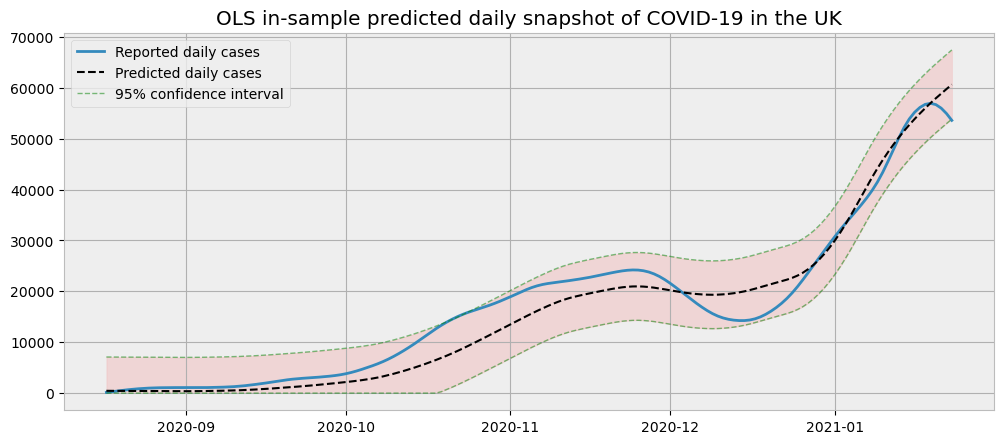

In [176]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

predstd, lb, ub = wls_prediction_std(lm)
lb[lb < 0] = 0 # Zero negative cases in the lower bound of the CI

f, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(ZC, lw=2)
ax.plot(lm.fittedvalues, "k--", lw=1.5)
ax.plot(lb, "g--", lw=1, alpha=0.5)
ax.plot(ub, "g--", lw=1, alpha=0.5)
ax.fill_between(ZC.index, lb, ub, alpha=0.1, color="r")
ax.set_title("OLS in-sample predicted daily snapshot of COVID-19 in the UK")
ax.legend(["Reported daily cases", "Predicted daily cases", "95% confidence interval"]);

In [177]:
total_ZC = int(np.sum(ZC))
total_predicted = int(np.ceil(np.sum(lm.fittedvalues)))

direction = "overestimates" if total_predicted > total_ZC else "underestimates"
delta = (total_predicted - total_ZC) / total_ZC

print(f"The true number of total cases in Italy from Augusgt 16th, 2020 until January 22nd, 2021 is {total_ZC}.")
print(f"The OLS model predicts the total to be {total_predicted}, which {direction} by {np.abs(delta):.4f}%.")

The true number of total cases in Italy from Augusgt 16th, 2020 until January 22nd, 2021 is 2729194.
The OLS model predicts the total to be 2547849, which underestimates by 0.0664%.


# Backcast implied cases

Apply the model to the deaths of the first wave.

C:\Users\Gebruiker\anaconda3\envs\TLRenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Gebruiker\anaconda3\envs\TLRenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


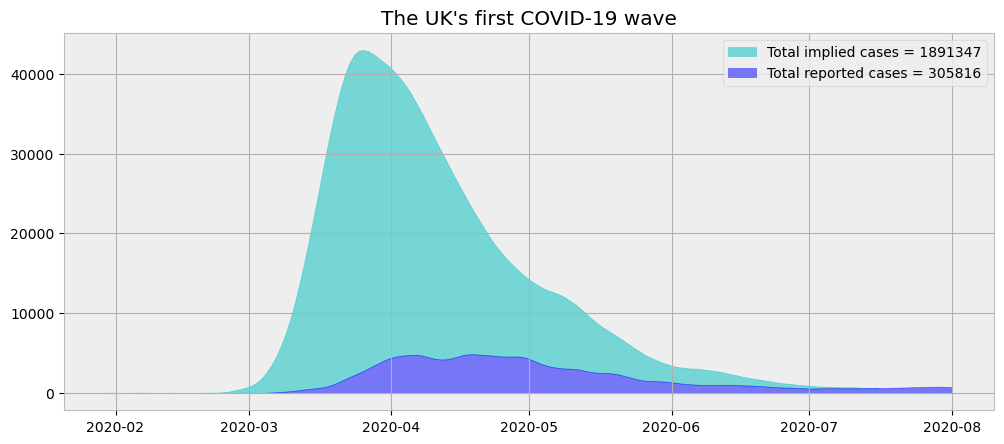

In [178]:
cases  = UnobservedComponents(data.loc[:switch_point]["Daily New Cases"], level="strend", seasonal=7).fit()
deaths = UnobservedComponents(data.loc[:switch_point]["Daily New Deaths"], level="strend", seasonal=7).fit()

s_cases  = np.ceil(cases.level["smoothed"])
s_deaths = np.ceil(deaths.level["smoothed"])

l_data = pd.DataFrame(np.array([s_cases, s_deaths]).T,
                      index=data[:switch_point].index,
                      columns=cols,
                      dtype=int)
l_data[l_data < 0] = 0

#l_data.plot(**kw2);
#plt.tight_layout()

p_cases = np.ceil(lm.predict(l_data["Daily Deaths Trend"]).shift(t_shift))
implied_true = int(np.sum(p_cases))
reported = data.loc[switch_point]["Cumulative Cases"]

f, ax = plt.subplots(1, 1, figsize=(12,5))
ax.fill_between(l_data.index, s_cases, p_cases, alpha=0.5, color="c")
ax.fill_between(l_data.index, 0, s_cases, alpha=0.5, color="b")
ax.set_title("The UK's first COVID-19 wave")
ax.legend([f"Total implied cases = {implied_true}", f"Total reported cases = {reported}"]);

# Conclusions

In [179]:
print(f"The number of total reported cases in the UK during the first wave is {reported}.")
print(f"The OLS model predicts the true total to be {implied_true}, which is {implied_true/reported:.1f} times more.\n")
print(f"Therefore, the OLS model estimates that the true total infected in the UK is {implied_true+total_ZC} people.")

The number of total reported cases in the UK during the first wave is 305816.
The OLS model predicts the true total to be 1891347, which is 6.2 times more.

Therefore, the OLS model estimates that the true total infected in the UK is 4620541 people.


# Gaussian Process

Use a common supervised machine learning technique. Best output is achieved when confined to the 2D uniform box $[0, 1] \times [0, 1]$.

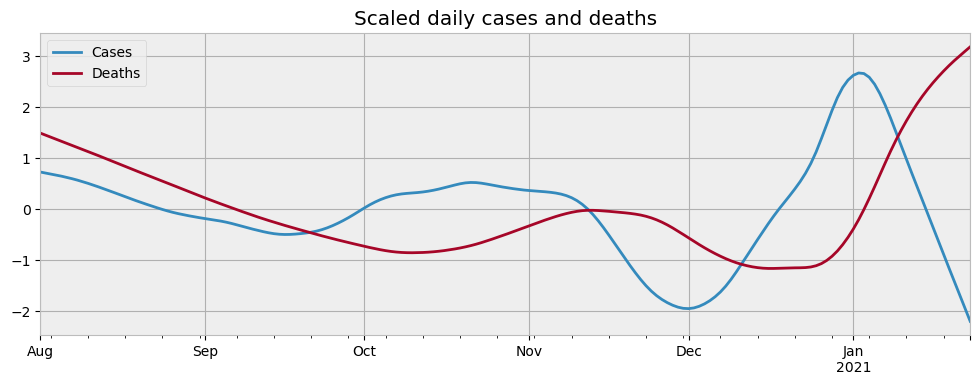

In [180]:
scaled_cycles.plot(figsize=(12, 4), title="Scaled daily cases and deaths", xlabel="");

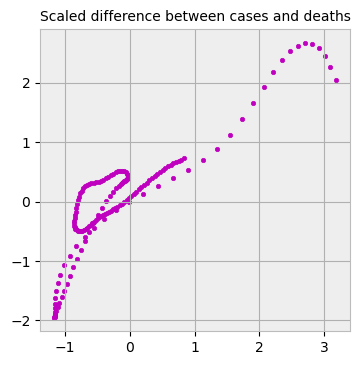

In [181]:
X = scaled_cycles["Deaths"].iloc[-t_shift:].values
Y = scaled_cycles["Cases"].shift(-t_shift).iloc[-t_shift:].values

f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(X, Y, color="m", s=10)
ax.set_title("Scaled difference between cases and deaths", fontsize=10);

In [182]:
import torch
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    
    def __init__(self, train_x, train_y, likelihood):
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
    
    def forward(self, x):
        
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [183]:
# Convert to tensors
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(Y, dtype=torch.float32)

In [184]:
Likelihood = gpytorch.likelihoods.GaussianLikelihood()
Model = ExactGPModel(X_train, y_train, Likelihood)

Likelihood.train()
Model.train()

optimiser = torch.optim.Adam(Model.parameters(), lr=1e-2)
criterion = gpytorch.mlls.ExactMarginalLogLikelihood(Likelihood, Model)

epochs = 500
losses = []

import time

t1 = time.time()

for i in range(epochs):
    
    i+=1
    
    y_pred = Model(X_train)
    loss = -criterion(y_pred, y_train)
    losses.append(loss)
    
    optimiser.zero_grad() # Zero gradients from previous iteration
    loss.backward() # Backpropagation
    
    if (i % 50 == 0 or i == 1):
        print(f"Epoch {i:3} \t Loss: {loss.item():2.5f} \t" \
              f"Length scale: {Model.covar_module.base_kernel.lengthscale.item():5.3f} \t" \
              f"Noise: {Model.likelihood.noise.item():5.5f}")
    
    optimiser.step()
    
t2 = time.time()

print(f"\n Model training took {t2-t1:.1f} seconds.")

Epoch   1 	 Loss: 0.89444 	Length scale: 0.693 	Noise: 0.69325
Epoch  50 	 Loss: 0.72843 	Length scale: 0.910 	Noise: 0.47671
Epoch 100 	 Loss: 0.55937 	Length scale: 0.967 	Noise: 0.31308
Epoch 150 	 Loss: 0.40424 	Length scale: 0.980 	Noise: 0.20274
Epoch 200 	 Loss: 0.28301 	Length scale: 0.982 	Noise: 0.13448
Epoch 250 	 Loss: 0.20878 	Length scale: 0.982 	Noise: 0.09547
Epoch 300 	 Loss: 0.17673 	Length scale: 0.985 	Noise: 0.07511
Epoch 350 	 Loss: 0.16776 	Length scale: 0.993 	Noise: 0.06570
Epoch 400 	 Loss: 0.16610 	Length scale: 1.003 	Noise: 0.06198
Epoch 450 	 Loss: 0.16580 	Length scale: 1.014 	Noise: 0.06074
Epoch 500 	 Loss: 0.16569 	Length scale: 1.025 	Noise: 0.06040

 Model training took 4.0 seconds.


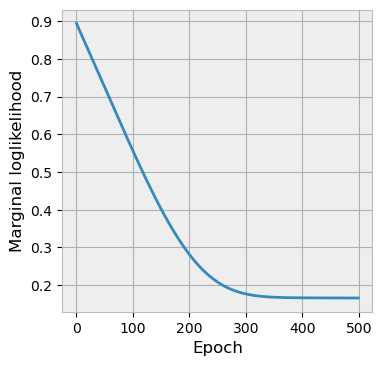

In [185]:
fig = plt.figure(figsize=(4, 4))

plt.plot(np.arange(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Marginal loglikelihood");

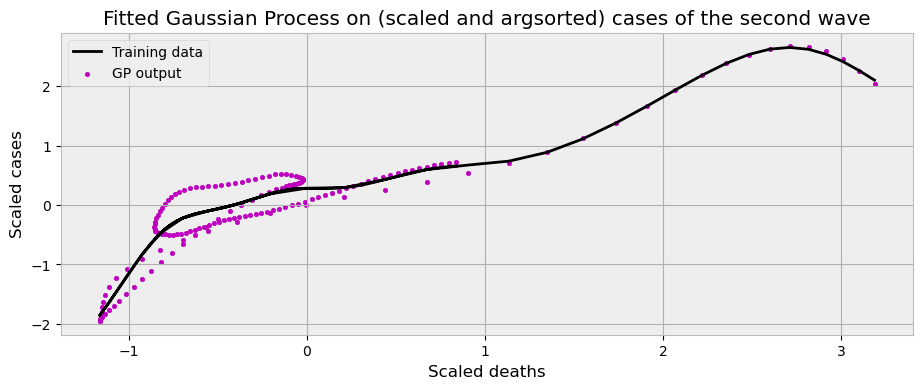

In [186]:
Likelihood.eval()
Model.eval()

with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize = (11, 4))
    
    GP_pred = Likelihood(Model(X_train))
    l, u = GP_pred.confidence_region()
    
    ax.scatter(X_train.numpy(), y_train.numpy(), s=10, color="m")
    ax.plot(X_train.numpy(), GP_pred.mean.numpy(), color="k")
    #ax.fill_between(X_train.numpy(), l.numpy(), u.numpy(), alpha=0.2, color="k")
    ax.set_xlabel("Scaled deaths")
    ax.set_ylabel("Scaled cases")
    ax.set_title("Fitted Gaussian Process on (scaled and argsorted) cases of the second wave")
    ax.legend(["Training data", "GP output", "95% confidence"])  

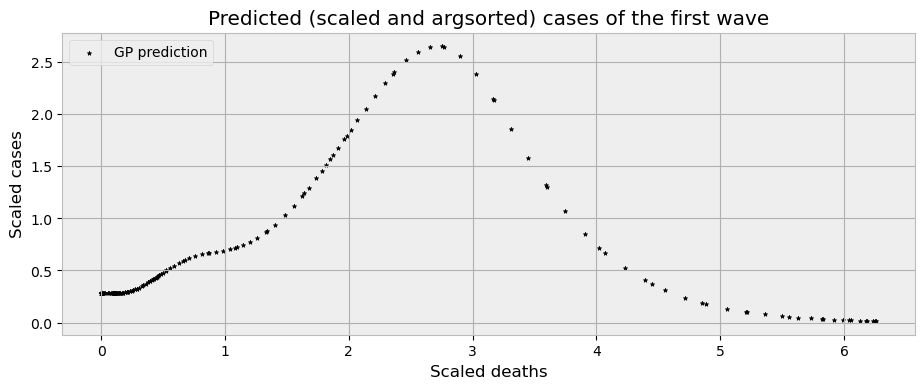

In [187]:
Likelihood.eval()
Model.eval()

X_test = torch.tensor(standard_scaler.transform(l_data)[:,1], dtype=torch.float32)

with torch.no_grad():
    
    GP_test = Likelihood(Model(X_test))
    l, u = GP_test.confidence_region()
    
    f, ax = plt.subplots(1, 1, figsize = (11, 4))
    ax.scatter(X_test.numpy(), GP_test.mean.numpy(), s=10, color="k", marker="*")
    #ax.fill_between(X_test.numpy(), l.numpy(), u.numpy(), alpha=0.2, color="b")
    ax.set_xlabel("Scaled deaths")
    ax.set_ylabel("Scaled cases")
    ax.set_title("Predicted (scaled and argsorted) cases of the first wave")
    ax.legend(["GP prediction", "95% confidence"],loc="upper left")

In [188]:
asdf = standard_scaler.inverse_transform(np.array([GP_test.mean.numpy(), X_test.numpy()]).T)

In [189]:
int(np.ceil(asdf[:,0]).sum())

822857